In [1]:
import pandas as pd
import sqlite3
import os
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import plotly.express as px

In C:\Users\wrope\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\wrope\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\wrope\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\wrope\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\wrope\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mpl

In [2]:
info_tiempos = pd.read_excel(r'ouput_times.xlsx')

# Preparación de los datos simulados para analisis

#### Función para leer datos

#### Exploración de datos

In [3]:
def conexion_bd(sql=None, database = None,update=True):
    
    sqlite3.register_adapter(np.int64, lambda val: int(val))
    sqlite3.register_adapter(np.int32, lambda val: int(val))

    con = sqlite3.connect(os.getcwd() + os.sep + database)
    
    try:
        if update == True:
            cur = con.cursor()
            cur.execute(sql)
            con.commit()
            df=None
        else:
            df= pd.read_sql_query(sql, con=con)
    except:
        print(sql)
        df=None
    con.close()
    
    return df

In [4]:
df1 = conexion_bd(sql='select*from parametros', database = 'result_op.db',update=False) 
df2 = conexion_bd(sql='select*from parametros', database = 'result_op__.db',update=False)
df = pd.concat([df1,df2]).drop_duplicates().reset_index(drop=True)

In [15]:
df2[df2['id_simulacion']==10]

,id_simulacion,n_pv,n_dg,p_dg,min_dg,efi_dg,lpsp,p_bat,cond_init_bat,val_aux_bateria,...,plim,oym_dg,asc,lcoe,asc_incentivo,lcoe_incentivo,cost_e_dg,cost_e_pv,cost_e_bat,cost_e_ens
113,10,190,1,10.0,0.9,1,0.05,40.32,40.32,0.01,...,79900.0,13597737.29,17016.74,0.54,16237.73,0.51,2736.86,63.56,931.6,1355.5


In [5]:
len(df.query('optimizacion=="optimal"' ))

125

In [6]:
df3 = conexion_bd(sql="""select id_simulacion, energia_PV, energia_Dg, 
                        energia_carga_bateria, energia_descarga_bateria, 
                        energia_ENS, "SOC(t)_bateria",load, p_bat_pv, p_bat_dg 
                        from resultados""",
                  database='result_op.db',
                  update=False)
df4 = conexion_bd(sql="""select id_simulacion, energia_PV, energia_Dg, 
                        energia_carga_bateria, energia_descarga_bateria, 
                        energia_ENS, "SOC(t)_bateria", load, p_bat_pv, 
                        p_bat_dg from resultados""",
                  database='result_op__.db',
                  update=False)
df0 = pd.concat([df3, df4]).reset_index(drop=True)

In [7]:
def promedio_horas_sin_servicio(bd,id):
    conteo_horas =  conexion_bd(sql=f"""select id_simulacion,
                            energia_ENS, energia_Dg from resultados where id_simulacion={id}""",
                      database=bd,
                      update=False)
    def horas(x):
        if x>0:
            y=1
        else:
            y=0
        return y
    conteo_horas["hora_ens"] = conteo_horas['energia_ENS'].apply(lambda x: horas(x))
    horas = conteo_horas['hora_ens'].to_list()
    def chunks(lst, n):
        """Yield successive n-sized chunks from lst."""
        for i in range(0, len(lst), n):
            yield lst[i:i + n]
    nueva_horas = list(chunks(horas, 24))        
    lista_horas = [sum(i) for i in nueva_horas]
    return (id,round(sum(lista_horas)/365,1))

In [8]:
busqueda =  df2['id_simulacion'].to_list()
busqueda = list(dict.fromkeys(busqueda))
print(busqueda) 
#df2['id_simulacion'].to_list() +
busqueda2 =  df1['id_simulacion'].to_list()
busqueda2 = list(dict.fromkeys(busqueda2))

[29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 58, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 200, 300, 400, 500, 600, 700, 800, 900, 901, 902, 903, 904, 905, 906, 907, 909]


In [9]:
len(busqueda2)

17

In [18]:
promedio_horas_sin_servicio('result_op.db',1007)

(1007, 2.6)

In [84]:
horas1 = [promedio_horas_sin_servicio('result_op__.db',i) for i in busqueda]    
horas2 = [promedio_horas_sin_servicio('result_op.db',i) for i in busqueda2]    

In [85]:
horas_final = pd.DataFrame(horas1+horas2).sort_values(by=1, ascending=False)
horas_final.columns = ['id_simulacion','h_sin_servicio']
horas_final['h_con_servicio'] = horas_final['h_sin_servicio'].apply(lambda x: 24-x)

In [123]:
len(horas_final)

137

In [90]:
df0 = df0.groupby('id_simulacion').sum().reset_index()

In [134]:
df_analisis = df.merge(df0, left_on='id_simulacion', right_on='id_simulacion')
df_analisis = df_analisis.merge(info_tiempos,
                       left_on='id_simulacion',
                       right_on='id_simulacion',
                       how='left')
df_analisis = df_analisis.merge(horas_final,
                       left_on='id_simulacion',
                       right_on='id_simulacion',
                       how='left')

In [137]:
df_analisis = df_analisis.drop_duplicates(subset ="id_simulacion")

In [138]:
df_analisis.drop_duplicates()

,id_simulacion,n_pv,n_dg,p_dg,min_dg,efi_dg,lpsp,p_bat,cond_init_bat,val_aux_bateria,...,energia_descarga_bateria,energia_ENS,SOC(t)_bateria,load,p_bat_pv,p_bat_dg,gap_percentaje,time_seconds,h_sin_servicio,h_con_servicio
0,110,379,1,0.0,0.0,1,0.05,120.96,120.96,0.01,...,46903.635155,9673.377226,1.545402e+06,145867.8140,68871.219445,0.0,0.0001,1.71,10.7,13.3
4,111,378,1,0.0,0.0,1,0.05,120.96,120.96,0.01,...,34960.130237,7784.991602,8.328204e+05,109400.8605,48395.032348,0.0,0.0001,2.25,10.6,13.4
8,112,420,1,0.0,0.0,1,0.05,80.64,80.64,0.01,...,34983.212695,7720.533455,8.331031e+05,109400.8605,48424.746024,0.0,0.0002,2.26,10.5,13.5
12,117,420,1,0.0,0.0,1,0.05,100.80,100.80,0.01,...,11806.510784,1604.400016,6.080199e+05,36466.9535,19362.848090,0.0,0.0000,2.28,2.4,21.6
13,1000,420,1,0.0,0.0,1,0.05,100.80,100.80,0.01,...,11806.510784,1604.400016,6.080199e+05,36466.9535,19362.848090,0.0,0.0000,2.13,2.4,21.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,904,400,1,0.0,0.0,1,0.10,120.96,120.96,0.01,...,12086.802823,1497.446377,7.115401e+05,36466.9535,20634.254429,0.0,0.0001,1.78,2.1,21.9
125,905,399,1,0.0,0.0,1,0.05,120.96,120.96,0.01,...,12082.181065,1511.189635,7.114748e+05,36466.9535,20628.246576,0.0,0.0002,5.08,2.1,21.9
126,906,398,1,0.0,0.0,1,0.05,120.96,120.96,0.01,...,12077.618071,1524.908029,7.116138e+05,36466.9535,20624.192095,0.0,0.0001,2.75,2.1,21.9
127,907,390,1,0.0,0.0,1,0.10,120.96,120.96,0.01,...,12038.758792,1638.469308,7.131143e+05,36466.9535,20592.580336,0.0,0.0004,2.03,2.3,21.7


In [139]:
df_analisis.columns

Index(['id_simulacion', 'n_pv', 'n_dg', 'p_dg', 'min_dg', 'efi_dg', 'lpsp',
       'p_bat', 'cond_init_bat', 'val_aux_bateria', 'DOD', 'n_bat',
       'self_dis_coef', 'max_ciclos_descarga', 'efficiency_inversor',
       'efficiency_charging', 'C_rate', 'cost_pv', 'cost_dg', 'cost_bat',
       'cost_pens', 'optimizacion', 'lpsp_result', 'ens_result',
       'ciclos_bat_result', 'vida_proyecto', 'ir', 'crf', 'cpv_ins',
       'cbat_ins', 'cdg_ins', 'capital_cpv', 'capital_cbat', 'capital_cdg',
       'kbat', 'kdg', 'ybat', 'ydg', 'rc_bat', 'rc_dg', 'factor_bat',
       'factor_pv', 'oym_pv', 'oym_bat', 'ipp_actual', 'trm', 'pami', 'plim',
       'oym_dg', 'asc', 'lcoe', 'asc_incentivo', 'lcoe_incentivo', 'cost_e_dg',
       'cost_e_pv', 'cost_e_bat', 'cost_e_ens', 'energia_PV', 'energia_Dg',
       'energia_carga_bateria', 'energia_descarga_bateria', 'energia_ENS',
       'SOC(t)_bateria', 'load', 'p_bat_pv', 'p_bat_dg', 'gap_percentaje',
       'time_seconds', 'h_sin_servicio', 'h_con_

In [140]:
df_analisis['energy_dg'] = df_analisis['p_bat_dg'] +df_analisis['energia_Dg'] 

In [141]:
df_analisis[['lpsp_result','lpsp']].head()

,lpsp_result,lpsp
0,4.97,0.05
4,0.00,0.05
8,0.00,0.05
12,4.40,0.05
13,4.40,0.05


In [148]:
df_1 =df_analisis.query('optimizacion=="optimal" and p_dg !=0 and lpsp_result>5')[['lpsp_result','id_simulacion']].head(15)
df_1.columns = ['lpsp','id_simulacion']
df_1['lpsp']=df_1['lpsp'].apply(lambda x: x/100)
df_1['id_simulacion']=df_1['id_simulacion'].apply(lambda x: str(x)+'_')
df_1['Type'] ="RESULT"
df_2 =df_analisis.query('optimizacion=="optimal" and p_dg !=0 and lpsp_result>5')[['lpsp','id_simulacion']].head(15)
df_2['Type'] ="OBJETIVE"
df_2['id_simulacion']=df_2['id_simulacion'].apply(lambda x: str(x)+'_')

df_lpsp = pd.concat([df_1,df_2])

<AxesSubplot:xlabel='lpsp_result', ylabel='h_sin_servicio'>

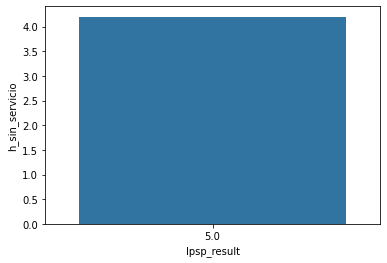

In [149]:
sns.barplot(data=df_analisis.drop_duplicates().query('optimizacion=="optimal" and id_simulacion==10 and p_dg !=0 '),
             x='lpsp_result',
             y='h_sin_servicio')

In [150]:
fig = px.bar(df_lpsp.drop_duplicates(),
             x='id_simulacion',
             y='lpsp',color='Type',template="ygridoff",width=520,barmode='group',
              height=400)
fig.update_yaxes(nticks=8)
fig.update_xaxes(nticks=10)
fig.update_xaxes(title_text='Simulation')
fig.update_yaxes(title_text='LPSP')
fig.update_xaxes(showline=True, linecolor='black')
fig.layout.update(showlegend=True) 
fig.update_yaxes(showline=True, linecolor='black')
fig.update_layout(
    font_family="Times New Roman",
    title_font_family="Times New Roman",
    font_size=14
    ,
    font_color="black",
        legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1,
        font_size=14)
       
)

fig.show()

fig.write_image("lpsp_vs_lpsp_result.eps")

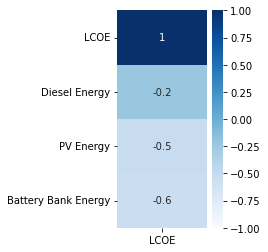

In [12]:
data_cor = df_analisis.query('optimizacion=="optimal" ')[[
    'energia_PV', 'energia_descarga_bateria', 'energy_dg', 'asc','lcoe'
    ]]

data_cor.columns = ['PV Energy', 'Battery Bank Energy', 'Diesel Energy', 'ASC', 'LCOE']

plt.figure(figsize=(2, 4))
heatmap = sns.heatmap(data_cor[['PV Energy', 'Battery Bank Energy', 'Diesel Energy', 'LCOE']].corr()[[
    'LCOE',
]].sort_values(by='LCOE', ascending=False),
    vmin=-1,
    vmax=1,
    annot=True,cmap='Blues', fmt='0.1g')
plt.savefig('lcoe_correlation.eps',bbox_inches='tight')

Text(0.5, 1.0, 'Features Correlating with Sales Price')

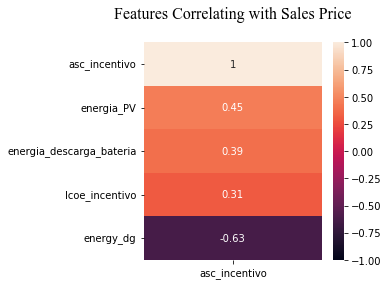

In [13]:
['PV Energy', 'Battery Bank Energy', 'Diesel Energy', 'ASC', 'LCOE']

plt.figure(figsize=(4, 4))
heatmap = sns.heatmap(df_analisis.query('optimizacion=="optimal" ')[[
    'energia_PV', 'energia_descarga_bateria', 'energy_dg', 'asc_incentivo',
    'lcoe_incentivo'
]].corr()[[
    'asc_incentivo',
]].sort_values(by='asc_incentivo', ascending=False),
    vmin=-1,
    vmax=1,
    annot=True)
heatmap.set_title('Features Correlating with Sales Price',
                  fontdict={
                      'fontsize': 16,
                      'fontfamily': 'Times New Roman'
                  },
                  pad=24)

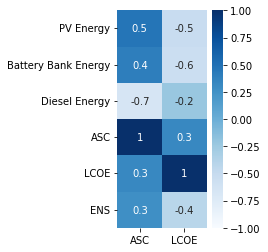

In [14]:
data_cor = df_analisis.query('optimizacion=="optimal" ')[[
    'energia_PV', 'energia_descarga_bateria', 'energy_dg', 'asc','lcoe','energia_ENS'
    ]]

data_cor.columns = ['PV Energy', 'Battery Bank Energy', 'Diesel Energy', 'ASC', 'LCOE','ENS']

plt.figure(figsize=(2, 4))
heatmap = sns.heatmap(data_cor[['PV Energy', 'Battery Bank Energy', 'Diesel Energy', 'ASC','LCOE','ENS']].corr()[[
    'ASC','LCOE'
]],
    vmin=-1,
    vmax=1,
    annot=True,cmap='Blues', fmt='0.1g')

plt.savefig('asc_lcoe_correlation.eps',bbox_inches='tight')

In [15]:
import os
os.getcwd()

'C:\\Users\\wrope\\Documents\\01. UdeA\\00. Tesis\\09. Implementacion\\dimensionamiento_microrred'

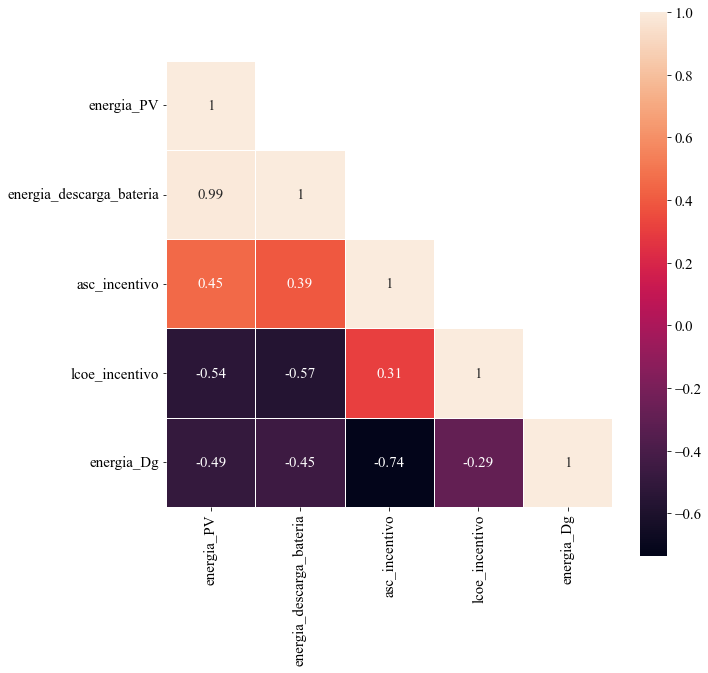

In [16]:
corrMatrix = df_analisis.query('optimizacion=="optimal" ')[[
    'energia_PV', 'energia_descarga_bateria',
    'asc_incentivo', 'lcoe_incentivo', 'energia_Dg']].corr()

lower_triang_df = corrMatrix.where(np.tril(np.ones(corrMatrix.shape)).astype(np.bool))

plt.figure(figsize=(10, 10))
plt.rcParams.update({'font.size': 15,'font.family':'Times New Roman'})




sns.heatmap(lower_triang_df,
            annot=True,
            annot_kws={"size": 15},
            square=True,
            linewidths=.5)
plt.show()

<AxesSubplot:xlabel='energia_PV', ylabel='Density'>

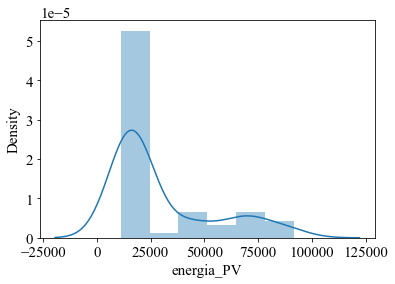

In [17]:
sns.distplot( df_analisis.query('optimizacion=="optimal" and p_dg !=0 ')["energia_PV"])

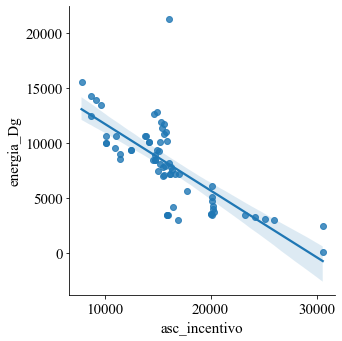

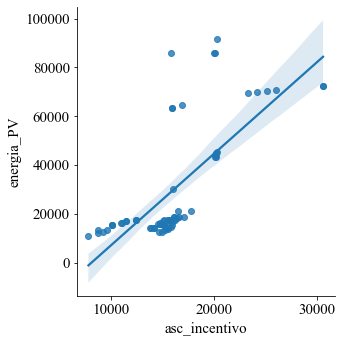

In [18]:
sns.lmplot(x="asc_incentivo", y="energia_Dg", data=df_analisis.query('optimizacion=="optimal" and p_dg !=0 '));
sns.lmplot(x="asc_incentivo", y="energia_PV", data=df_analisis.query('optimizacion=="optimal" and p_dg !=0 '));

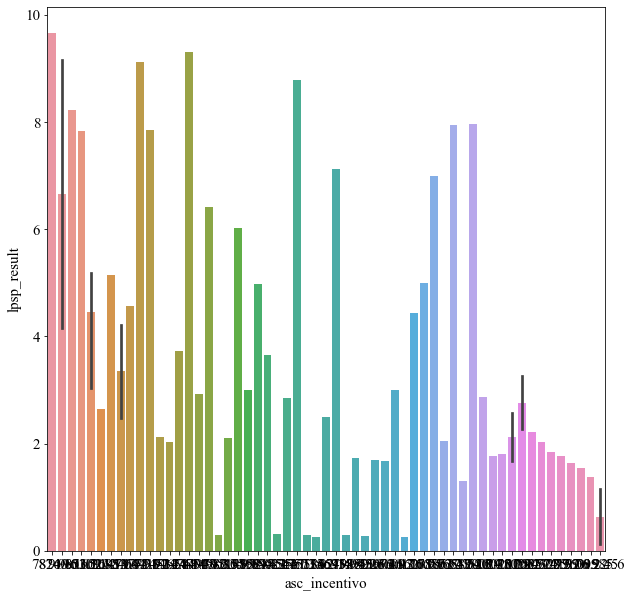

In [26]:
plt.figure(figsize=(10, 10))
sns.barplot(data=df_analisis.query('optimizacion=="optimal" and p_dg !=0 '), x="asc_incentivo", y="lpsp_result")
plt.show()

In [105]:
bubble_plot1=df_analisis.query('optimizacion=="optimal" and p_dg !=0 ')[["lcoe_incentivo","energia_Dg"]]
bubble_plot1.columns = ['LCOE','energia']
bubble_plot1["Type"]= 'Diesel Energy'
#'PV Energy', 'Battery Bank Energy', 'Diesel Energy',
bubble_plot2=df_analisis.query('optimizacion=="optimal" and p_dg !=0 ')[["lcoe_incentivo","energia_descarga_bateria"]]
bubble_plot2.columns = ['LCOE','energia']
bubble_plot2["Type"]= 'Battery Bank Energy'
#################33
bubble_plot3=df_analisis.query('optimizacion=="optimal" and p_dg !=0 ')[["lcoe_incentivo","energia_PV"]]
bubble_plot3.columns = ['LCOE','energia']
bubble_plot3["Type"]= 'PV Energy'

In [106]:
analisis_final = pd.concat([bubble_plot3,bubble_plot2,bubble_plot1], axis =0)

In [107]:
fig = px.scatter(analisis_final, x="LCOE", y="energia",
	         size="energia", color="Type",
                 hover_name="energia", log_x=True, size_max=15,template="ygridoff",width=520,
              height=400)
fig.update_yaxes(nticks=8)
fig.update_xaxes(nticks=5)
fig.update_xaxes(title_text='LCOE')
fig.update_yaxes(title_text='Total Energy (kWh/year)')
fig.update_xaxes(showline=True, linecolor='black')
fig.layout.update(showlegend=True) 
fig.update_yaxes(showline=True, linecolor='black')
fig.update_layout(
    font_family="Times New Roman",
    title_font_family="Times New Roman",
    font_size=14
    ,
    font_color="black",
        legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1,
        font_size=14)
       
)

fig.show()

fig.write_image("energy_lcoe_bubble.eps")

In [108]:
bubble_plot1=df_analisis.query('optimizacion=="optimal" and p_dg !=0 ')[["asc_incentivo","energia_Dg"]]
bubble_plot1.columns = ['ASC','energia']
bubble_plot1["Type"]= 'Diesel Energy'
#'PV Energy', 'Battery Bank Energy', 'Diesel Energy',
bubble_plot2=df_analisis.query('optimizacion=="optimal" and p_dg !=0 ')[["asc_incentivo","energia_descarga_bateria"]]
bubble_plot2.columns = ['ASC','energia']
bubble_plot2["Type"]= 'Battery Bank Energy'
#################33
bubble_plot3=df_analisis.query('optimizacion=="optimal" and p_dg !=0 ')[["asc_incentivo","energia_PV"]]
bubble_plot3.columns = ['ASC','energia']
bubble_plot3["Type"]= 'PV Energy'

In [109]:
analisis_final = pd.concat([bubble_plot3,bubble_plot2,bubble_plot1], axis =0)

In [110]:
fig = px.scatter(analisis_final, x="ASC", y="energia",
	         size="energia", color="Type",
                 hover_name="energia", log_x=True, size_max=15,template="ygridoff",width=520,
              height=400)
fig.update_yaxes(nticks=8)
fig.update_xaxes(nticks=5)
fig.update_xaxes(title_text='ASC')
fig.update_yaxes(title_text='Total Energy (kWh/year)')
fig.update_xaxes(showline=True, linecolor='black')
fig.layout.update(showlegend=True) 
fig.update_yaxes(showline=True, linecolor='black')
fig.update_layout(
    font_family="Times New Roman",
    title_font_family="Times New Roman",
    font_size=14
    ,
    font_color="black",
        legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1,
        font_size=14)
       
)

fig.show()

fig.write_image("energy_asc_bubble.eps")

# Preguntas de investigación

### ¿El costo baja o sube cuando aumenta el uso de la generación diésel?

### ¿Cómo se comporta el modelo al variar el LPSP?

### ¿ El modelo mejora la prestación del servicio comparado con lo que esta actual?

### ¿Cómo se comporta el tiempo de convergencia del modelo al variar los parametros?

### ¿Qué tipo de problema de opt es y cómo se comporta en solvers de tipo libre (COIN)?